# **Coffee Production Prediction**

In [1]:
# Importing Required Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report


In [2]:
# load diffent data files

df_paths = [
    './DataSets/Coffee-Production-Datasets/domestic-consumption.csv',
    './DataSets/Coffee-Production-Datasets/exports-calendar-year.csv',
    './DataSets/Coffee-Production-Datasets/exports-crop-year.csv',
    './DataSets/Coffee-Production-Datasets/gross-opening-stocks.csv',
    './DataSets/Coffee-Production-Datasets/total-production.csv'
]

In [3]:
dfs = [pd.read_csv(df_path) for df_path in df_paths]


In [4]:
def get_means(df):
    df = df.copy()
    countries = df[df.columns[0]]
    means = df.mean(axis=1)
    df = pd.concat([countries, means], axis=1)
    df.columns = ['country', countries.name]
    return df

In [5]:
def make_df(dfs):
    
    # Process all DataFrames
    processed_dfs = []
    
    for df in dfs:
        processed_dfs.append(get_means(df))
        
    # Merge DataFrames
    df = processed_dfs[0]
    
    for i in range(1, len(processed_dfs)):
        df = df.merge(processed_dfs[i], on='country')
    
    return df

In [6]:
# Combining different data files to make a dataset to predict coffee production from 1990 to 2018
data = make_df(dfs)
data.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_22824\94857722.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = df.mean(axis=1)
C:\Users\USER\AppData\Local\Temp\ipykernel_22824\94857722.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = df.mean(axis=1)
C:\Users\USER\AppData\Local\Temp\ipykernel_22824\94857722.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = df.mean(axis=1)
C:\Users\USER\AppData\Local\Temp\ipykernel_22824\94857722.py:4: FutureWarning: Dropping 

,country,domestic_consumption,exports,exports_crop_year,gross_opening_stocks,total_production
0,Angola,25.689655,24.115531,23.187083,42.068966,45.256048
1,Bolivia (Plurinational State of),41.103448,78.384152,76.904748,7.237931,116.146128
2,Brazil,15234.310345,25706.195606,25919.128803,23213.206897,41067.783976
3,Burundi,1.891966,363.186423,356.056321,48.979690,350.172424
4,Ecuador,214.137931,1115.800914,1105.434110,108.592069,1076.504352


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 55
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               56 non-null     object 
 1   domestic_consumption  56 non-null     float64
 2   exports               56 non-null     float64
 3   exports_crop_year     56 non-null     float64
 4   gross_opening_stocks  56 non-null     float64
 5   total_production      56 non-null     float64
dtypes: float64(5), object(1)
memory usage: 3.1+ KB


In [8]:
data.shape

(56, 6)

In [9]:
data.isnull().sum()

country                 0
domestic_consumption    0
exports                 0
exports_crop_year       0
gross_opening_stocks    0
total_production        0
dtype: int64

In [10]:
data.duplicated().sum()

0

In [11]:
data.describe()


,domestic_consumption,exports,exports_crop_year,gross_opening_stocks,total_production
count,56.000000,56.000000,56.000000,56.000000,56.000000
mean,598.190822,1659.518787,1675.821731,649.819970,2209.623978
std,2081.814904,4089.426252,4148.578684,3109.283691,6018.038152
min,0.000000,0.063966,0.063966,0.000000,0.063966
25%,4.934638,30.332257,29.494833,4.586207,44.738335
50%,59.965517,173.106854,166.062226,39.224138,330.032916
75%,325.562914,1338.744688,1367.453200,157.386466,1499.984847
max,15234.310345,25706.195606,25919.128803,23213.206897,41067.783976


In [12]:
cor=data.corr()


Text(0.5, 1.0, 'Correlation among all the Variables of the Dataset')

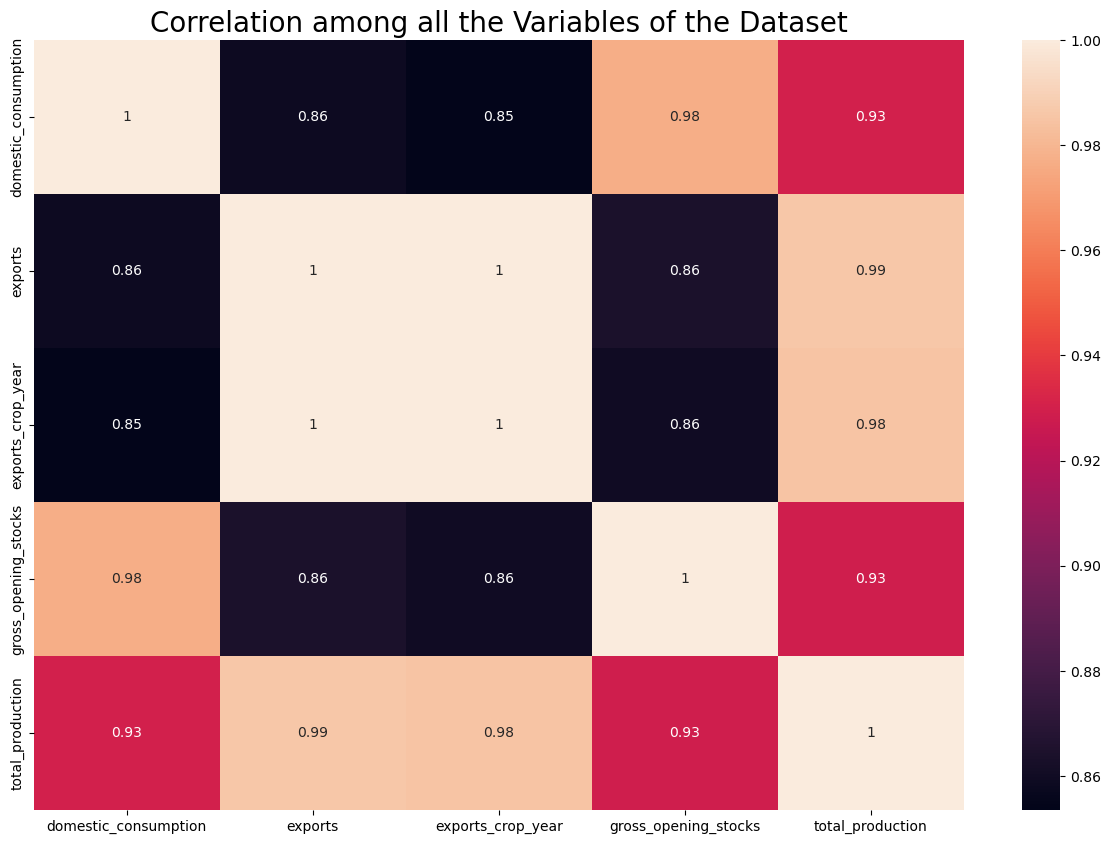

In [13]:

#Checking relationship between variables
plt.figure(figsize=(15,10), facecolor='w')
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,annot=True)
plt.title("Correlation among all the Variables of the Dataset", size=20)


In [14]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop country column
    df = df.drop('country', axis=1)
    
    # Split df into X and y
    y = df['total_production']
    X = df.drop('total_production', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)


In [16]:
X_train


,domestic_consumption,exports,exports_crop_year,gross_opening_stocks
52,-0.288283,0.892275,0.873300,1.747068
35,-0.521580,-0.437099,-0.426357,-0.515553
26,-0.179496,0.702419,0.649249,1.699879
45,-0.468220,-0.434885,-0.424262,-0.514958
54,1.051480,5.195041,5.259387,2.681623
27,-0.218160,-0.248307,-0.263722,-0.441956
34,-0.454459,-0.340175,-0.332771,-0.458617
13,-0.521855,-0.403943,-0.395213,-0.476602
22,-0.405190,-0.094064,-0.124317,-0.123369
47,-0.520582,-0.416036,-0.407476,-0.484707


In [17]:
y_train


52     3211.943759
35        5.872314
26     2658.525303
45       45.642441
54    15156.584548
27      589.295686
34      274.420314
13       75.645990
22      770.235855
47       48.227941
30     4880.789417
17      389.662476
51       14.417234
31        1.539900
23      104.515079
4      1076.504352
14        3.847172
29        0.580517
28     1598.384334
50      161.011238
40      300.162076
18      501.272379
55      107.300966
20       43.185197
25     2016.203052
6       587.719424
7        46.716359
53     1121.038724
1       116.146128
16      508.823210
0        45.256048
15      201.634176
5      8452.302438
11      309.893407
9        34.678362
8      1010.334755
12       35.874466
43        0.856041
37     4552.609690
Name: total_production, dtype: float64

In [18]:
# Linear Regression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

lr_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print("RMSE: {:.2f}".format(lr_rmse))

lr_r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
print("R^2: {:.5f}".format(lr_r2))

RMSE: 587.70
R^2: 0.99628


In [19]:
# Lasso Regression

model = Lasso(alpha=0.1, max_iter = 10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

lasso_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print("RMSE: {:.2f}".format(lasso_rmse))

lasso_r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
print("R^2: {:.5f}".format(lasso_r2))

RMSE: 562.75
R^2: 0.99659


In [20]:
# Ridge Regression

'''params = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge_reg = GridSearchCV(Ridge(), param_grid = params, cv = 5, scoring = 'r2')
ridge_reg.fit(X_train, y_train)
print(ridge_reg.best_estimator_)'''

# BEST HYPERPARAMETERS FOR THE MODEL USING GRID SEARCH CV
model = Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ridg_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print("RMSE: {:.2f}".format(ridg_rmse))

ridg_r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
print("R^2: {:.5f}".format(ridg_r2))


RMSE: 202.90
R^2: 0.99956


C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [21]:
# Support Vector Regression

'''params = [{'C': [1,10,100,1000,10000], 'epsilon': [0.0001,0.001,0.01,0.1,1],
          'kernel': ['poly'], 'degree':[2,3,4]},
          {'C': [1,10,100,1000,10000], 'epsilon': [0.0001,0.001,0.01,0.1,1],
          'kernel': ['rbf']}]

svr_reg = GridSearchCV(SVR(),param_grid = params, scoring = 'r2', cv = 5)
svr_reg.fit(X_train, y_train)

print(svr_reg.best_estimator_)'''


# BEST HYPERPARAMETERS FOR THE MODEL USING GRID SEARCH CV
model = SVR(C=10000, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001, gamma='scale',
            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

sv_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print("RMSE: {:.2f}".format(sv_rmse))

sv_r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
print("R^2: {:.5f}".format(sv_r2))

RMSE: 8643.10
R^2: 0.19579


In [22]:
# GradientBoostingRegressor

'''params = {'n_estimators': [50, 100, 200, 300],
          'max_depth': [8,10,12,14,16],
          'min_samples_split': [2,3,4],
          'subsample':[0.1, 0.2]}

gb_reg = GridSearchCV(GradientBoostingRegressor() ,param_grid = params, scoring = 'r2', cv = 5)
gb_reg.fit(X_train, y_train)

print(gb_reg.best_estimator_)'''

# BEST HYPERPARAMETERS FOR THE MODEL USING GRID SEARCH CV
model = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=12,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, 
                          min_samples_leaf=1, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, 
                          random_state=None, subsample=0.2, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

gb_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print("RMSE: {:.2f}".format(gb_rmse))

gb_r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
print("R^2: {:.5f}".format(gb_r2))

RMSE: 6010.41
R^2: 0.61110


C:\Users\USER\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


In [23]:
# Decision Tree Regression

'''params  = {'splitter': ['best', 'random'],'min_samples_leaf': [1, 2 ,3],
           'max_depth': [6,8,10,12,14,16,18]}

tree_reg = GridSearchCV(DecisionTreeRegressor(random_state = 0) ,param_grid = params, scoring = 'r2', cv = 5)
tree_reg.fit(X_train, y_train)

print(tree_reg.best_estimator_)'''

# BEST HYPERPARAMETERS FOR THE MODEL USING GRID SEARCH CV
model = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, 
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, 
                      random_state=0, splitter='best')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

dt_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print("RMSE: {:.2f}".format(dt_rmse))

dt_r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
print("R^2: {:.5f}".format(dt_r2))

RMSE: 6381.03
R^2: 0.56166


C:\Users\USER\anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


In [24]:
# Random Forest Regression

'''params = {
    'bootstrap': [True],
    'max_depth': [8, 10, 12, 14, 16],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [40, 50, 60, 70],
    'max_features': [0.3, 0.4, 0.5]
}

forest_reg = GridSearchCV(RandomForestRegressor(), param_grid = params, scoring = 'r2', cv = 5)
forest_reg.fit(X_train, y_train)

print(forest_reg.best_estimator_)'''

# BEST HYPERPARAMETERS FOR THE MODEL USING GRID SEARCH CV
model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=70, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rf_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print("RMSE: {:.2f}".format(rf_rmse))

rf_r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
print("R^2: {:.5f}".format(rf_r2))

C:\Users\USER\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


RMSE: 7821.45
R^2: 0.34143


## **Models Evaluation**

In [25]:
model_ev = pd.DataFrame({'Model': ['Linear Regression','Lasso Regression','Ridge Regression',
                                   'Support Vector Regression','Gradient Boosting Regressor','Decision Tree Regression','Random Forest Regression'], 
                         'RMSE': [lr_rmse, lasso_rmse, ridg_rmse, sv_rmse, gb_rmse,
                                      dt_rmse, rf_rmse],
                         'R^2': [lr_r2, lasso_r2, ridg_r2, sv_r2, gb_r2, dt_r2, rf_r2]})
model_ev

,Model,RMSE,R^2
0,Linear Regression,587.702473,0.996282
1,Lasso Regression,562.750463,0.996591
2,Ridge Regression,202.901006,0.999557
3,Support Vector Regression,8643.103741,0.195790
4,Gradient Boosting Regressor,6010.411811,0.611100
5,Decision Tree Regression,6381.033368,0.561659
6,Random Forest Regression,7821.452238,0.341426


* From above data we see that for ridge model Root Mean Square Value is minimum and R2 Score is maximum.
* So we choose ridge model for our final prediction.

## **Prediction By Best Model**

In [26]:
# Ridge Regression

ridge_model = Ridge()

ridge_model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ridg_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print("RMSE: {:.2f}".format(ridg_rmse))

ridg_r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
print("R^2: {:.5f}".format(ridg_r2))


RMSE: 7821.45
R^2: 0.34143


In [27]:
ridge_model.predict([[40,1000,1000,100]])

C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


array([2494322.02869545])